In [40]:
%cd ../../

/home/matej/prace


In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
from imageio import imread
import numpy as np
import os
from os.path import join
from scripts.CNN.train_interactions import COLUMNS, match_pred_to_gt, model
import pandas as pd
from scripts.CNN.interactions_results import toarray, tostruct
import warnings
pd.set_option('precision', 2)
import seaborn as sns
sns.set()

In [42]:
DATA_DIR = '/home/matej/prace/ferda/data/interactions/1712_36k_random'
EXPERIMENT_DIR = '/home/matej/prace/ferda/experiments/180118_2231_dim_mask'
SUB_EXPERIMENT = 0.857142857143

In [4]:
y_test = pd.read_csv(join(DATA_DIR, 'test.csv'))    

with h5py.File(join(EXPERIMENT_DIR, str(SUB_EXPERIMENT), 'predictions.h5'), 'r') as hf:
    pred = hf['data'][:]
    pred_df = pd.DataFrame(tostruct(pred))
    
loss_alpha_batch = pd.read_csv(join(EXPERIMENT_DIR, 'results.csv'))    

n_objects = pred_df.shape[1] / len(COLUMNS)
assert pred_df.shape[1] % len(COLUMNS) == 0

In [5]:
for i in range(n_objects):
    y_test['%d_angle_deg' % i] *= -1

In [6]:
loss_alpha_batch[loss_alpha_batch['loss_alpha'].round(4) == round(SUB_EXPERIMENT, 4)]

,Unnamed: 0,xy MAE,angle MAE,loss_alpha
12,12,6.29,9.03,0.86


In [7]:
loss_alpha_batch.loc[loss_alpha_batch.index[-1], 'xy MAE'] = np.nan
xy = loss_alpha_batch['xy MAE']
loss_alpha_batch['xy MAE norm'] = (xy - xy.mean()) / xy.std()
#loss_alpha_batch['angle MAE'].iloc[0] = np.nan
angle = loss_alpha_batch['angle MAE']
loss_alpha_batch['angle MAE norm'] = (angle - angle.mean()) / angle.std()
loss_alpha_batch['sum norm'] = loss_alpha_batch['angle MAE norm'] + loss_alpha_batch['xy MAE norm']
loss_alpha_batch['alpha sum norm'] = loss_alpha_batch['angle MAE norm'] * (1 - loss_alpha_batch['loss_alpha']) + \
                                     loss_alpha_batch['xy MAE norm'] * loss_alpha_batch['loss_alpha']

In [8]:
# ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE norm', 'angle MAE norm', 'alpha sum norm'], 
#                            title='normalized mean absolute errors')
# ax.legend(['xy', 'angle', 'alpha weighted sum'])
# ax.set_xlabel('alpha')

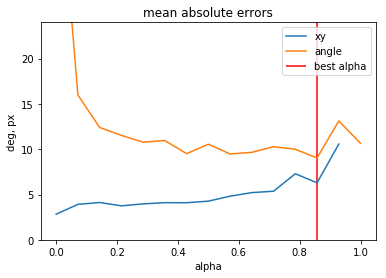

In [17]:
ax = loss_alpha_batch.plot('loss_alpha', ['xy MAE', 'angle MAE'], title='mean absolute errors')
ax.set_ylabel('deg, px')
ax.set_xlabel('alpha')
ax.set_ylim(0, 24)
ax.vlines(SUB_EXPERIMENT, ax.get_ylim()[0], ax.get_ylim()[1],
          'r')
ax.legend(['xy', 'angle', 'best alpha'])

# Predictions

In [18]:
pred_df.describe()

,0_x,0_y,0_major,0_minor,0_angle_deg,1_x,1_y,1_major,1_minor,1_angle_deg
count,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00,3600.00
mean,111.04,99.93,47.37,37.07,75.93,90.73,100.59,-38.92,-23.56,74.53
std,5.88,11.82,14.51,17.43,54.02,7.08,11.49,22.10,34.68,54.83
min,94.68,66.67,9.45,-14.16,-59.02,72.49,71.01,-94.42,-116.00,-59.19
25%,106.81,90.50,37.84,25.58,33.16,85.20,91.80,-55.49,-54.69,31.81
50%,110.98,99.04,44.87,35.94,72.45,90.75,98.64,-41.41,-10.39,76.41
75%,115.20,110.11,55.15,46.22,118.93,95.98,109.89,-22.73,4.33,117.89
max,130.39,132.96,104.27,118.65,211.31,111.82,132.14,33.47,39.62,203.09


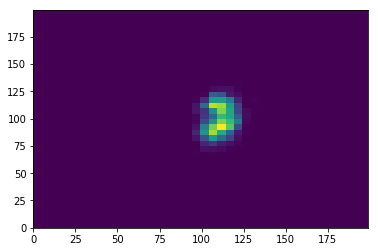

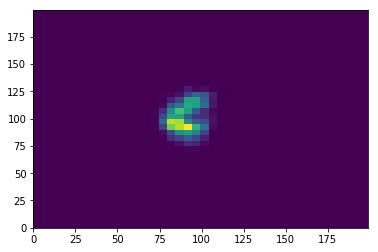

In [39]:
for i in range(n_objects):
    plt.figure()
    _ = plt.hist2d(pred_df['%d_x' % i], pred_df['%d_y' % i], bins=40, range=((0, 199), (0, 199)))

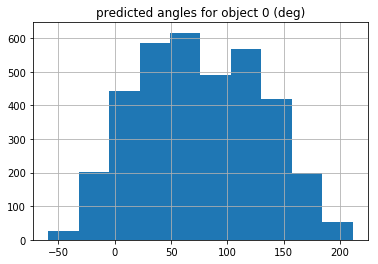

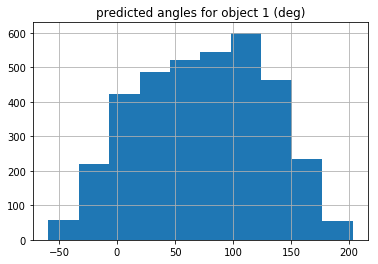

In [36]:
for i in range(n_objects):
    plt.figure()
    plt.title('predicted angles for object %d (deg)' % i)
    (pred_df['%d_angle_deg' % i]).hist()

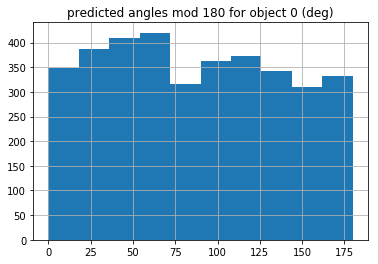

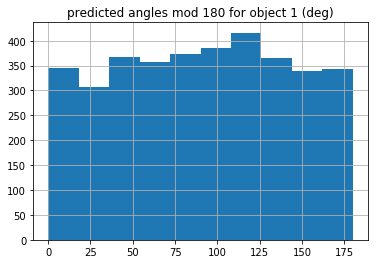

In [37]:
for i in range(n_objects):
    plt.figure()
    plt.title('predicted angles mod 180 for object %d (deg)' % i)
    (pred_df['%d_angle_deg' % i] % 180).hist()

# Prediction Errors

In [27]:
PRED_COLUMNS = ['x', 'y', 'major', 'minor', 'angle_deg']
columns = []
for i in range(n_objects):
    columns.extend(['%d_%s' % (i, c) for c in PRED_COLUMNS])

xy, angle, indices = match_pred_to_gt(pred_df[columns].values, y_test[columns].values, np)
if n_objects == 1:
    xy_errors = xy
    angle_errors = angle
elif n_objects == 2:
    xy_errors = (xy[indices[:, 0], indices[:, 1]])
    angle_errors = (angle[indices[:, 0], indices[:, 1]])
else:
    assert False, 'not implemented'

# swap = indices[:, 0] == 1
# pred_swapped = pred.copy()
# pred_swapped[swap, :5], pred_swapped[swap, 5:] = pred_swapped[swap, 5:], pred_swapped[swap, :5]

In [44]:
indices

array([[   1,    0],
       [   1,    1],
       [   1,    2],
       ..., 
       [   0, 3597],
       [   1, 3598],
       [   0, 3599]])

In [35]:
df = pd.DataFrame.from_items([('xy (px)', [xy_errors.mean()]), 
                              ('angle (deg)', angle_errors.mean()),])
df.style.set_caption('MAE')
df

,xy (px),angle (deg)
0,6.29,9.03


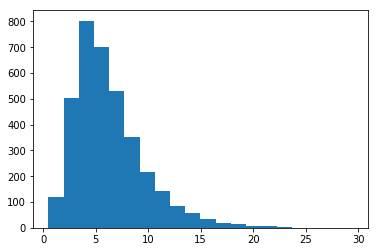

In [29]:
_  = plt.hist(xy_errors, 20)

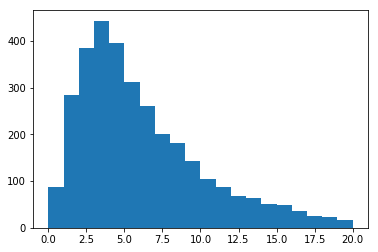

In [30]:
_ = plt.hist(angle_errors, 20, range=(0, 20))

In [ ]:
plt.hist2d()

In [43]:
for i in range(n_objects):
    plt.figure()
    _ = plt.hist2d(pred_df['%d_x' % i], pred_df['%d_y' % i], bins=40, range=((0, 199), (0, 199)))

array([  9.45,   8.94,   6.59, ...,   3.21,   7.43,  10.55])

# Model

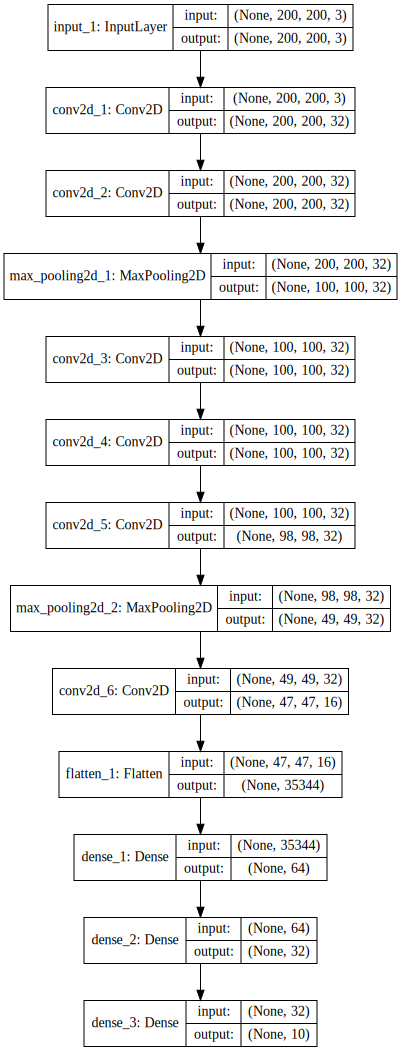

In [31]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model(), show_shapes=True).create(prog='dot', format='svg'))

In [32]:
# SVG(model_to_dot(model.get_layer('model_1'), show_shapes=True).create(prog='dot', format='svg'))